<a href="https://colab.research.google.com/drive/1fvDBaa6-qc6ggwK37cQe7JZN1fqGhqjG#scrollTo=view-in-github" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network (DNN)



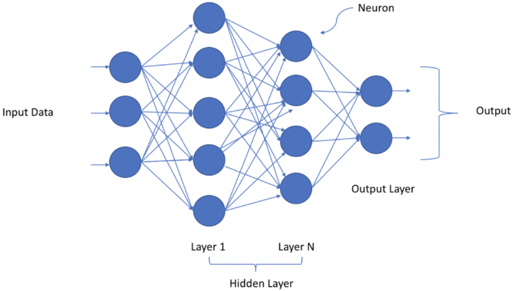

In [1]:
''' import '''
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional.regression import mean_squared_error, mean_absolute_percentage_error, pearson_corrcoef
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler

from utils import set_all, load_data, split_data, check_data, train, evaluate, plot_hist

In [2]:
''' set '''
device, data_path, output_path = set_all(os.getcwd())

In [3]:
''' load data '''
X, Y = load_data(data_path, '500')
X = X / 255.0

scaler = MinMaxScaler()
X_tr, X_ts, Y_tr, Y_ts = split_data(X,Y, test_size=0.2, device=device, scaler=scaler)

print(X_tr.shape, X_ts.shape)
print (Y_tr.shape,Y_ts.shape)

torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
torch.Size([400, 1]) torch.Size([100, 1])


In [6]:
# check_data(X,Y)

In [7]:
''' model '''
class DNN(nn.Module):
    def __init__(self, fc_fts, sigmoid=True):
        super(DNN, self).__init__()

        self.flatten = nn.Flatten()

        self.fcs = nn.ModuleList()
        in_ft = fc_fts[0]

        for i in range(len(fc_fts)-2): # dropout, relu o
            out_ft = fc_fts[i+1]
            self.fcs.append(nn.Linear(in_ft, out_ft))
            self.fcs.append(nn.Dropout(0.3))
            self.fcs.append(nn.ReLU())
            in_ft = out_ft

        out_ft = fc_fts[-1] # dropout, relu x
        self.fcs.append(nn.Linear(in_ft, out_ft))

        if sigmoid:
            self.fcs.append(nn.Sigmoid())

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.fcs:
            x = layer(x)

        return x

In [8]:
# dnn = DNN(fc_fts=[56*56, 1024, 512, 256, 256, 1], sigmoid=True).to(device)

# summary(dnn, (1, 56, 56))  # input shape: (channels, height, width)
# dnn

In [10]:
''' hyper params '''

# model
dnn = DNN(fc_fts=[56*56, 1024, 512, 256, 256, 1], sigmoid=True).to(device)

# hyper param
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

# loss, optim, scaduler
criterion = nn.MSELoss()
optimizer = optim.Adam(params=dnn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

# data loader
train_loader = DataLoader(TensorDataset(X_tr, Y_tr), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_ts, Y_ts), batch_size=len(X_ts))

In [11]:
''' train '''
loss_tr_hist = []
loss_val_hist = []

for epoch in range(num_epochs):

    # train, valid
    loss_tr = train(dnn, train_loader, criterion, optimizer)
    loss_val = evaluate(dnn, test_loader, criterion)
    scheduler.step()
    
    # history
    loss_tr_hist.append(loss_tr)
    loss_val_hist.append(loss_val)
    print(f'Epoch [{epoch+1:3}/{num_epochs}], Tr loss: {loss_tr:.5f}, Val loss: {loss_val:.5f}')

Epoch [  1/50], Tr loss: 0.07459, Val loss: 0.07046
Epoch [  2/50], Tr loss: 0.07318, Val loss: 0.04722
Epoch [  3/50], Tr loss: 0.06083, Val loss: 0.04442
Epoch [  4/50], Tr loss: 0.05780, Val loss: 0.03777
Epoch [  5/50], Tr loss: 0.03954, Val loss: 0.03536
Epoch [  6/50], Tr loss: 0.03667, Val loss: 0.03190
Epoch [  7/50], Tr loss: 0.02936, Val loss: 0.03349
Epoch [  8/50], Tr loss: 0.02670, Val loss: 0.03241
Epoch [  9/50], Tr loss: 0.02456, Val loss: 0.02676
Epoch [ 10/50], Tr loss: 0.01923, Val loss: 0.02407
Epoch [ 11/50], Tr loss: 0.01892, Val loss: 0.02387
Epoch [ 12/50], Tr loss: 0.01854, Val loss: 0.02625
Epoch [ 13/50], Tr loss: 0.01856, Val loss: 0.01999
Epoch [ 14/50], Tr loss: 0.01486, Val loss: 0.02278
Epoch [ 15/50], Tr loss: 0.01582, Val loss: 0.01954
Epoch [ 16/50], Tr loss: 0.01407, Val loss: 0.01971
Epoch [ 17/50], Tr loss: 0.01230, Val loss: 0.01639
Epoch [ 18/50], Tr loss: 0.01160, Val loss: 0.02107
Epoch [ 19/50], Tr loss: 0.01192, Val loss: 0.01882
Epoch [ 20/5

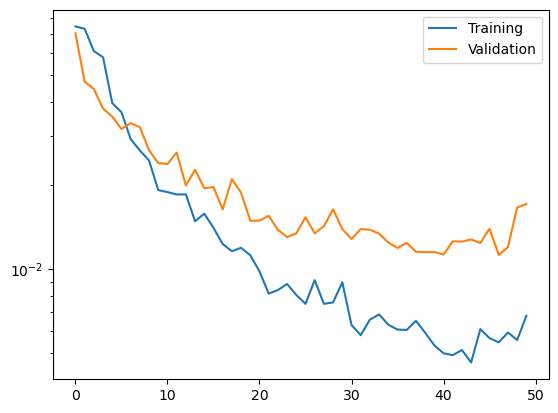

In [12]:
plot_hist(loss_tr_hist, loss_val_hist)

valid RMSE :  0.1309
valid MAPE :  0.189
valid R2 :  0.898


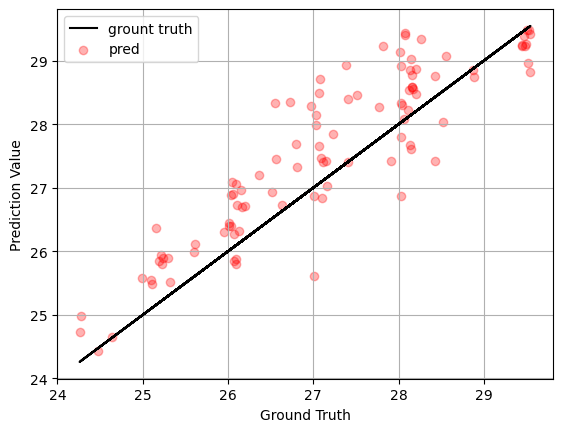

In [13]:
''' evaluation '''
dnn.eval()
y_pred = dnn(X_ts)

# RMSE, MAPE, R2 metrics
rmse = mean_squared_error(y_pred, Y_ts, squared=False).item()
mape = mean_absolute_percentage_error(Y_ts, y_pred).item()
r2 = pearson_corrcoef(y_pred, Y_ts).item()


# inverse transform
y_pred = y_pred.cpu().detach()
y_pred = scaler.inverse_transform(y_pred)

y_ts = Y_ts.cpu()
y_ts = scaler.inverse_transform(y_ts)


# plot
plt.plot(y_ts, y_ts, c='black')
plt.scatter(y_ts, y_pred, alpha=0.3, color='red')

plt.legend(['grount truth','pred'])
plt.xlabel('Ground Truth')
plt.ylabel('Prediction Value')
plt.grid()

print("valid RMSE : " , np.round(rmse,4))
print("valid MAPE : " , np.round(mape,4))
print("valid R2 : " , np.round(r2,4))